In [ ]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

pd.set_option('display.max_columns', None)

# **Loading Data**

In [ ]:
# read data
df = pd.read_csv('KAGGLE_DATA_ARTICLE_METHOD1_FEATURES.csv', index_col='Unnamed: 0')

# exclude cat cols
exclude_columns = ['ID', 'BirthYear', 'Gender', 'Tremors', 'DiagnosisYear', 'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other']
# cat_cols = ['Parkinsons', 'Gender', 'Tremors', 'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other']
df = df.drop(exclude_columns, axis=1)
df = df.fillna(0)

# **SMOTE/Borerline SMOTE/ADASYN**

In [ ]:
# smote
X = df.drop('Parkinsons', axis=1)
y = df['Parkinsons'].astype(int)
#sm = SMOTE(random_state=42)
#sm = BorderlineSMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

# **MinMax Scaling**

In [ ]:
# split samples
X_res_h = X_res[y_res==0]
X_res_p = X_res[y_res==1]

# split labels
y_res_h = y_res[y_res==0]
y_res_p = y_res[y_res==1]

# minmax
scaler = MinMaxScaler()
X_res_h_norm = scaler.fit_transform(X_res_h)
X_res_p_norm = scaler.fit_transform(X_res_p)

# **CWT**

In [ ]:
# cwt
wavelet = 'morl'
scales = np.arange(1, 21)
cwt_h_coeffs, cwt_h_scales = pywt.cwt(X_res_h_norm, scales, wavelet, method='conv')
cwt_p_coeffs, cwt_p_scales = pywt.cwt(X_res_p_norm, scales, wavelet, method='conv')

# Scale the CWT coefficients along the second and third axes
scaler = MinMaxScaler()
cwt_h_coeffs_scaled = scaler.fit_transform(cwt_h_coeffs.reshape(-1, cwt_h_coeffs.shape[-1])).reshape(cwt_h_coeffs.shape)
cwt_p_coeffs_scaled = scaler.fit_transform(cwt_p_coeffs.reshape(-1, cwt_p_coeffs.shape[-1])).reshape(cwt_p_coeffs.shape)

# concat
data = np.concatenate([cwt_h_coeffs_scaled, cwt_p_coeffs_scaled], axis=1).transpose(1, 0, 2) # (num_samples, num_scales, num_coefficients)
labels = np.concatenate([y_res_h, y_res_p])

# **Resize and Expand**

In [ ]:
# resize to 240x240
data = resize(data, (data.shape[0], 240, 240), anti_aliasing=True)

# expand channels
data = np.stack((data,) * 3, axis=-1)

# **Augmentation by Transformation**

In [ ]:
X = data
y = labels

import numpy as np
from PIL import Image
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    # transforms.RandomResizedCrop(size=(224, 224)),
    transforms.RandomRotation(degrees=40),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2),
    transforms.RandomAffine(degrees=0, translate=(0, 0.2), shear=(0, 0.2)),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.2)
])

# Cast input
image_data = np.uint8(X*255)

# Loop over each image in the dataset and apply the transformations
transformed_data = []
transformed_labels = []

for i in range(len(image_data)):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_data[i])
    
    # Apply the transformations to the PIL Image
    transformed_image1 = transform(image)
    transformed_image2 = transform(image)
    transformed_image3 = transform(image)
    
    # Add the transformed images to the list
    transformed_data.append(transformed_image1)
    transformed_data.append(transformed_image2)
    transformed_data.append(transformed_image3)

    transformed_labels += [y[i]] * 3

# Stack the transformed images together to get a tensor of size (900, 3, 224, 224)
transformed_data = np.stack(transformed_data)
transformed_labels = np.array(transformed_labels)

In [ ]:
data.shape

(313, 240, 240, 3)

In [ ]:
transformed_data.shape

(939, 240, 240, 3)

In [ ]:
# minmax
scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(transformed_data.reshape(-1, transformed_data.shape[-1])).reshape(transformed_data.shape)

In [ ]:
np.save('aug_img.npy', transformed_data.transpose(0,3,1,2))
np.save('aug_lbl.npy', transformed_labels)

# **CWT**

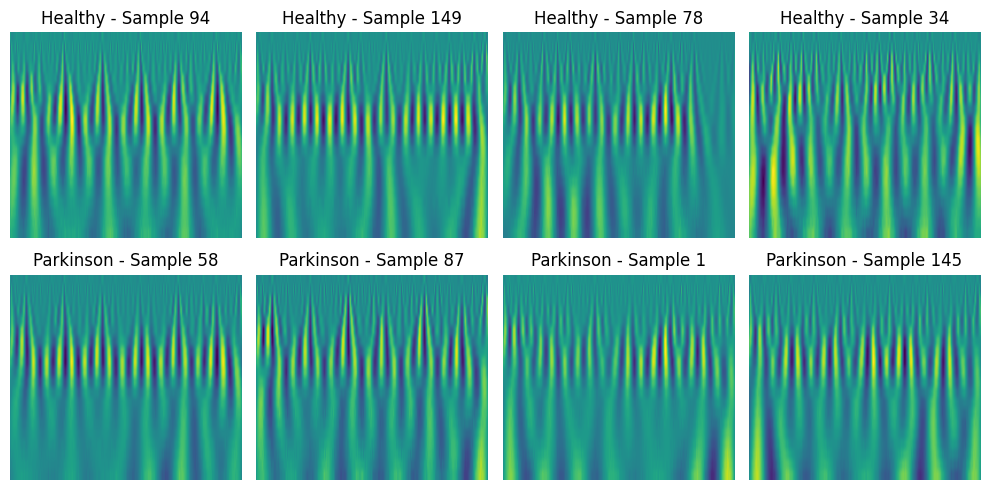

In [ ]:
# np.random.seed(42)
h_samples = np.random.choice(np.where(y_res_h == 0)[0], size=4, replace=False)
p_samples = np.random.choice(np.where(y_res_p == 1)[0], size=4, replace=False)

# Create a 2x4 plot of CWT coefficient images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

# Plot healthy samples in the first row
for i in range(4):
    idx = h_samples[i]
    cwt_coeffs = cwt_h_coeffs[:, idx, :]
    cwt_scales = cwt_h_scales
    ax[0, i].imshow(cwt_coeffs, cmap='viridis', aspect='auto', extent=[0, 1, cwt_scales[-1], cwt_scales[0]])
    ax[0, i].set_title(f'Healthy - Sample {idx}')
    ax[0, i].axis('off')

# Plot Parkinson's samples in the second row
for i in range(4):
    idx = p_samples[i]
    cwt_coeffs = cwt_p_coeffs[:, idx, :]
    cwt_scales = cwt_p_scales
    ax[1, i].imshow(cwt_coeffs, cmap='viridis', aspect='auto', extent=[0, 1, cwt_scales[-1], cwt_scales[0]])
    ax[1, i].set_title(f'Parkinson - Sample {idx}')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

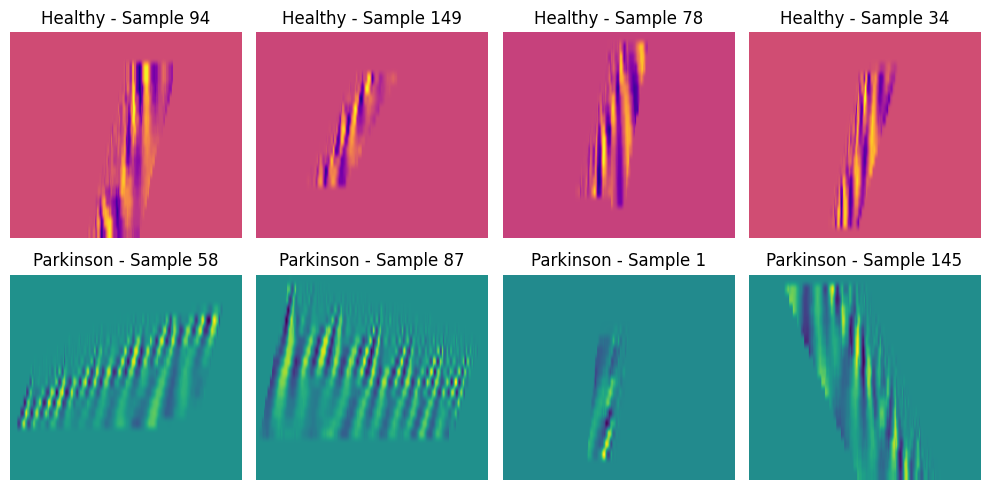

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.RandomRotation(degrees=40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0, 0.2), shear=(0, 0.2), scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=1),
    # transforms.ToTensor()
])

# Create a 2x4 plot of CWT coefficient images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

# Plot healthy samples in the first row
for i in range(4):
    idx = h_samples[i]
    cwt_coeffs = cwt_h_coeffs[:, idx, :]
    cwt_scales = cwt_h_scales
    
    # Convert the CWT coefficient image to a PIL Image
    cwt_image = Image.fromarray(cwt_coeffs)
    
    # Apply the transformations to the PIL Image
    transformed_image = transform(cwt_image)
    
    # Convert the transformed PIL Image back to a numpy array
    transformed_coeffs = np.array(transformed_image)
    
    ax[0, i].imshow(transformed_coeffs, cmap='plasma', aspect='auto', extent=[0, 1, cwt_scales[-1], cwt_scales[0]])
    ax[0, i].set_title(f'Healthy - Sample {idx}')
    ax[0, i].axis('off')

# Plot Parkinson's samples in the second row
for i in range(4):
    idx = p_samples[i]
    cwt_coeffs = cwt_p_coeffs[:, idx, :]
    cwt_scales = cwt_p_scales
    
    # Convert the CWT coefficient image to a PIL Image
    cwt_image = Image.fromarray(cwt_coeffs)
    
    # Apply the transformations to the PIL Image
    transformed_image = transform(cwt_image)
    
    # Convert the transformed PIL Image back to a numpy array
    transformed_coeffs = np.array(transformed_image)
    
    ax[1, i].imshow(transformed_coeffs, cmap='viridis', aspect='auto', extent=[0, 1, cwt_scales[-1], cwt_scales[0]])
    ax[1, i].set_title(f'Parkinson - Sample {idx}')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

data_loaded = np.load('aug_img.npy')
labels_loaded = np.load('aug_lbl.npy')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.init as init


from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total
    return avg_train_loss, train_accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)
            y_true += labels.tolist()
            y_pred += preds.tolist()
            
    loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return loss, accuracy, f1, cm



In [ ]:
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNet(nn.Module):
    def __init__(self, num_classes=2, dropout: float = 0.5):
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = x.view(x.size(0), self.num_classes)
        return x



In [ ]:
# Load the data from files
X = np.load('aug_img.npy')
y = np.load('aug_lbl.npy')

# Split the data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)


# Load the data from files
X = np.load('aug_img.npy')
y = np.load('aug_lbl.npy')

# Split the data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

# Create TensorDataset objects for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test))

# Create DataLoader objects for train, validation, and test sets
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SqueezeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_params = torch.numel(torch.nn.utils.parameters_to_vector(model.parameters()))

print(num_params)

best_loss = float('inf')
patience = 3
threshold = 0.4
counter = 0

tr_loss_hist, tr_acc_hist = [], []
val_loss_hist, val_acc_hist = [], []

for epoch in range(32):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, f1, cm = evaluate(model, val_loader, criterion, device)

    tr_loss_hist.append(train_loss)
    tr_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    
    print(f'Epoch {epoch+1}: TrLoss: {train_loss:.4f}, TrAcc: {train_acc:.4f} - ValLoss: {val_loss:.4f}, ValAcc: {val_acc:.4f}')

    # early stopping
    if val_loss < best_loss and val_loss > threshold:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break
        if  val_loss <= threshold:
            print(f'Validation loss crossed defined threshold {threshold}. Early stopping...')
            break

test_loss, test_acc, test_f1, test_cm = evaluate(model, test_loader, criterion, device)

723522


100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


Epoch 1: TrLoss: 0.6921, TrAcc: 0.5100 - ValLoss: 0.6936, ValAcc: 0.5143


100%|██████████| 100/100 [00:01<00:00, 61.35it/s]


Epoch 2: TrLoss: 0.6896, TrAcc: 0.5489 - ValLoss: 0.6847, ValAcc: 0.5857


100%|██████████| 100/100 [00:01<00:00, 60.94it/s]


Epoch 3: TrLoss: 0.6885, TrAcc: 0.5614 - ValLoss: 0.6809, ValAcc: 0.5714


100%|██████████| 100/100 [00:01<00:00, 63.99it/s]


Epoch 4: TrLoss: 0.6680, TrAcc: 0.6178 - ValLoss: 0.6877, ValAcc: 0.5143


100%|██████████| 100/100 [00:01<00:00, 64.44it/s]


Epoch 5: TrLoss: 0.6450, TrAcc: 0.6366 - ValLoss: 0.6484, ValAcc: 0.6286


100%|██████████| 100/100 [00:01<00:00, 64.60it/s]


Epoch 6: TrLoss: 0.5993, TrAcc: 0.6942 - ValLoss: 0.5751, ValAcc: 0.7000


100%|██████████| 100/100 [00:01<00:00, 64.38it/s]


Epoch 7: TrLoss: 0.5780, TrAcc: 0.7018 - ValLoss: 0.6330, ValAcc: 0.6000


100%|██████████| 100/100 [00:01<00:00, 63.57it/s]


Epoch 8: TrLoss: 0.5331, TrAcc: 0.7381 - ValLoss: 0.5572, ValAcc: 0.6286


100%|██████████| 100/100 [00:01<00:00, 63.52it/s]


Epoch 9: TrLoss: 0.5180, TrAcc: 0.7356 - ValLoss: 0.4913, ValAcc: 0.7429


100%|██████████| 100/100 [00:01<00:00, 60.18it/s]


Epoch 10: TrLoss: 0.4980, TrAcc: 0.7632 - ValLoss: 0.4886, ValAcc: 0.8143


100%|██████████| 100/100 [00:01<00:00, 62.33it/s]


Epoch 11: TrLoss: 0.4894, TrAcc: 0.7519 - ValLoss: 0.5390, ValAcc: 0.8143


100%|██████████| 100/100 [00:01<00:00, 64.04it/s]


Epoch 12: TrLoss: 0.4507, TrAcc: 0.7895 - ValLoss: 0.4335, ValAcc: 0.7857


100%|██████████| 100/100 [00:01<00:00, 63.67it/s]


Epoch 13: TrLoss: 0.4227, TrAcc: 0.8033 - ValLoss: 0.4314, ValAcc: 0.7857


100%|██████████| 100/100 [00:01<00:00, 64.17it/s]


Epoch 14: TrLoss: 0.3964, TrAcc: 0.8246 - ValLoss: 0.4064, ValAcc: 0.8000


100%|██████████| 100/100 [00:01<00:00, 63.27it/s]


Epoch 15: TrLoss: 0.3917, TrAcc: 0.8058 - ValLoss: 0.3492, ValAcc: 0.8429
Validation loss crossed defined threshold 0.4. Early stopping...


Test Loss: 0.3559, Test Accuracy: 0.9155 - f1_score: 0.9211


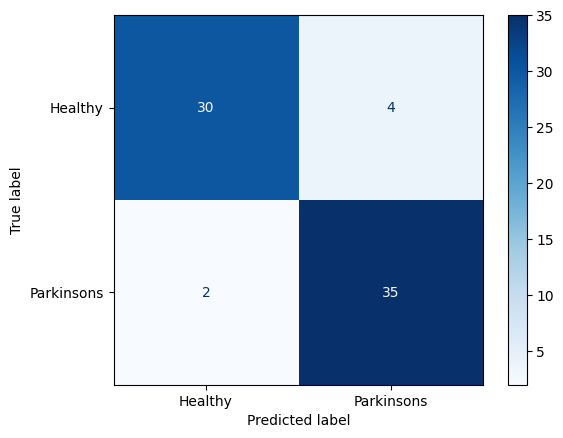

In [ ]:
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} - f1_score: {test_f1:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Healthy','Parkinsons'])

disp.plot(cmap="Blues");

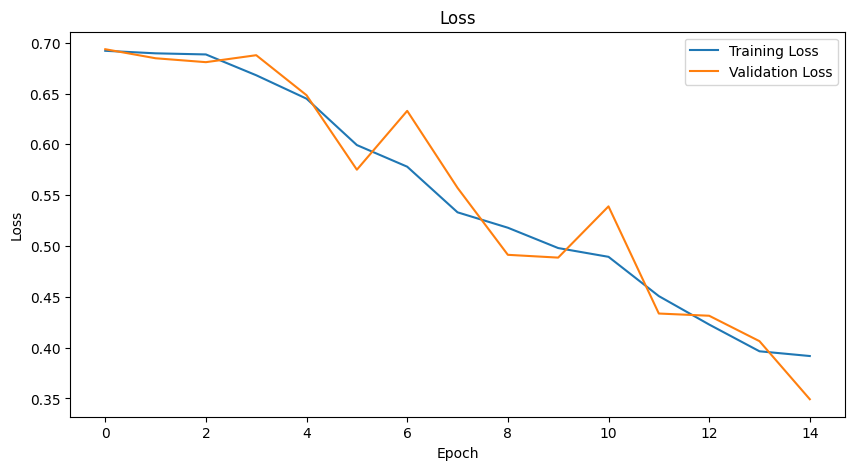

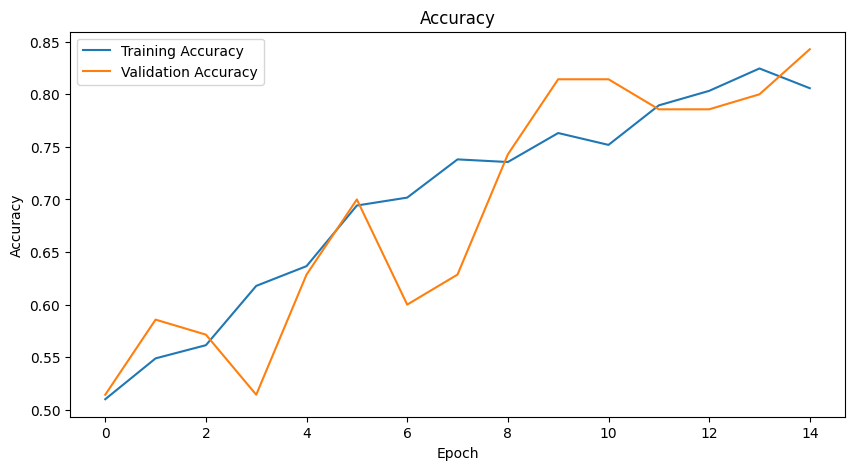

In [ ]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(tr_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(tr_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
